## Travel time to regional hubs
Use Mapbox API to calcuate travel time to major neighboring cities (population greater than 1mil).  
Use district centroids as origins

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from infrasap import mapbox_helper as mb
from shapely.wkt import loads

from dotenv import load_dotenv, find_dotenv

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
country = 'costarica'
iso3 = 'CRI'
epsg = 32616

In [5]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
mb_token = os.environ.get("MB_TOKEN")

### Load data

In [6]:
base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")
G_path = os.path.join(in_folder, 'graph', f"G_{iso3}.pickle")

base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/Major_Cities.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/global_settlement_points_v1_01_gt50000.shp'

In [7]:
target = gpd.read_file(focal_admin2)
target['centroid'] = target.centroid
cities = gpd.read_file(global_cities)

In [8]:
cities_filter = cities.copy()
cities_filter = cities_filter[cities_filter.Pop>500000].copy() # used to be 1 million, but that's not working for CR

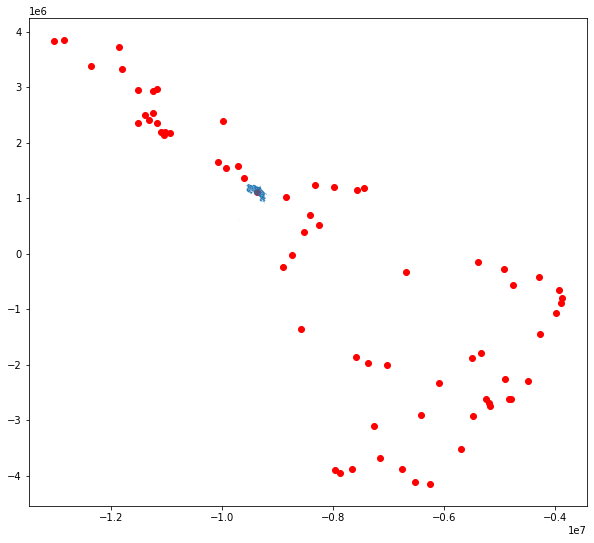

In [9]:
cities_filter = cities_filter.to_crs('EPSG:3857')
target = target.to_crs('EPSG:3857')

ax = cities_filter.plot(figsize=(10, 10), color='red')
target.plot(figsize=(7, 7), ax=ax)

In [10]:
# remove cities that are in the country of interest
adm0 = target.dissolve(by='WB_ADM0_CO')
cities_filter = cities_filter.loc[~cities_filter.intersects(adm0.geometry.iloc[0])]

# sort by distance to country
cities_filter['dist_to_ADM0'] = cities_filter.distance(adm0.centroid.iloc[0])
cities_filter = cities_filter.sort_values('dist_to_ADM0')

In [11]:
# choose destinations based on the nearest N cities. 
# N might change depending on the country, if the cities are too far apart use 5, otherwise the Mapbox requests will break
# If there are many cities close by, use 10
n_nearest = 5
cities_filter = cities_filter.head(n_nearest).to_crs(cities.crs)
target = target.to_crs(cities.crs)
target.crs == cities_filter.crs

True

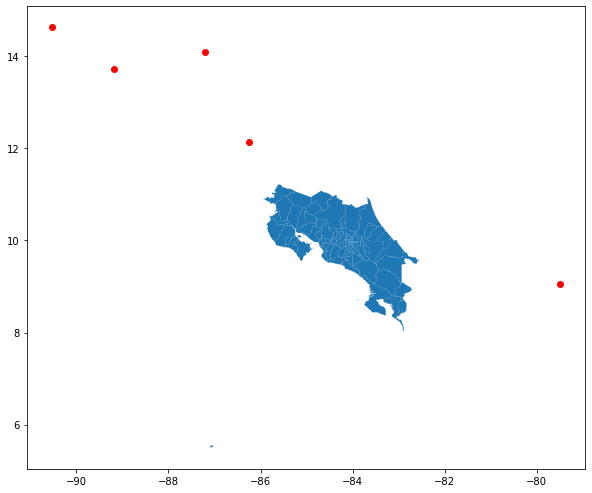

In [12]:
ax = cities_filter.plot(figsize=(10, 10), color='red')
target.plot(figsize=(7, 7), ax=ax)

In [13]:
origins = target.copy()
dests = cities_filter.copy().reset_index(drop=True)

In [14]:
origins['x'] = origins.centroid.x
origins['y'] = origins.centroid.y

dests['x'] = dests.geometry.x
dests['y'] = dests.geometry.y

origins['ID'] = origins.OBJECTID
dests['ID'] = dests.index

origins['Pop'] = 1
dests['Pop'] = 1

In [20]:
odRes = mb.CreateODMatrix(origins, dests, lat_name = 'y', lon_name = 'x', UID = 'ID',
                    Pop = 'Pop', call_type = 'MB', rescue = 0, rescue_num = 0, MB_Toke = mb_token,
                    sleepTime = 5, osrmHeader = '')


Chosen server: MB

Start time: Tue Aug  4 15:07:50 2020
source list: 81
sources list: 7
dest list: 5
dests list: 1

Estimated remaining calls to chosen server: 7

save points will occur every 1 calls

Call to OSRM server number: 1 of 7
Call to OSRM server number: 2 of 7
Call to OSRM server number: 3 of 7
Call to OSRM server number: 4 of 7
Call to OSRM server number: 5 of 7
Call to OSRM server number: 6 of 7
Call to OSRM server number: 7 of 7


In [21]:
odRes.head()

,D_UID,O_UID,DIST,O_POP,D_POP
0,0,13111,25937.9,1,1
1,1,13111,45041.1,1,1
2,2,13111,51996.8,1,1
3,3,13111,58799.9,1,1
4,4,13111,73397.0,1,1


In [24]:
OD_re = odRes.pivot(index='O_UID',columns='D_UID', values='DIST')
OD_re2 = OD_re.apply(lambda x: x/(60*60))

In [25]:
OD_re2.head()

D_UID,0,1,2,3,4
O_UID,,,,,
13111,7.204972,12.511417,14.443556,16.333306,20.388056
13112,7.317222,12.846556,14.555806,16.445556,20.500306
13113,6.545083,11.851528,13.783667,15.673417,19.728167
13114,7.741972,14.183417,14.980556,16.870306,20.925056
13115,5.819222,14.371750,13.057806,14.947556,19.002306


In [28]:
# get the min
OD_re3 = pd.DataFrame(OD_re2.idxmin(axis=1), columns=['ID']).join(pd.DataFrame(OD_re2.min(axis=1), columns=['tt_regional']))
# OD_re3 = pd.DataFrame(data=[OD_re2.idxmin(axis=1), OD_re2.min(axis=1)], index=['D_UID','time']).transpose()

In [29]:
OD_re3.head()

,ID,tt_regional
O_UID,,
13111,0,7.204972
13112,0,7.317222
13113,0,6.545083
13114,0,7.741972
13115,0,5.819222


In [31]:
OD_re3['OBJECTID'] = OD_re3.index.astype('int')
target_hubs = target.merge(OD_re3, on='OBJECTID')

Merge back destination hub name

In [39]:
target_hubs['ID'] = target_hubs['ID'].astype('int')

In [41]:
target_hubs2 = target_hubs.merge(dests[['Name','ID']], on='ID')

In [43]:
target_hubs2['Name'].value_counts()

Managua    75
Panam��     6
Name: Name, dtype: int64

In [45]:
target_hubs2.drop(['geometry','Shape_Leng','Shape_Area'], axis=1, inplace=True)

In [47]:
output_path = os.path.join(out_folder, 'tables')
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [50]:
target_hubs2.rename(columns={'tt_regional':'Time (hrs)', 'ID':'Regional Hub ID', 'Name':'Regional Hub Name'}, inplace=True)

In [51]:
target_hubs2.to_excel(os.path.join(output_path, "8Travel Time to Regional Hub.xlsx"), index=False)